## Maximize risk-adjusted return
$$ max \quad w^T\mu - \gamma w^T \Sigma w $$
$$ s.t. \quad w^T1 = 1 $$
$$ w >= 0 $$
$ w $ = asset weights <br>
$ \Sigma $ = Covariance matrix <br>
$ \gamma \in [0,\infty) $ = risk-aversion parameter 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import yfinance as yf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cvxpy as cp 
from tqdm.notebook import tqdm

plt.style.use('bmh')

In [3]:
tickers = ['AAPL', 'INTC', 'IBM', 'MSFT']
data = yf.download(tickers, period='5y', interval='1d', auto_adjust=True)
data.Close

[*********************100%***********************]  4 of 4 completed


,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-27,32.320953,135.802704,32.122066,59.957729
2017-02-28,32.335117,136.120651,31.849331,59.724350
2017-03-01,32.996029,137.733017,31.611786,60.620502
2017-03-02,32.800121,136.658112,31.594172,59.752361
2017-03-03,32.993668,136.294724,31.585382,59.976391
...,...,...,...,...
2022-02-18,167.300003,124.349998,45.040001,287.929993
2022-02-22,164.320007,123.919998,44.689999,287.720001
2022-02-23,160.070007,122.070000,44.650002,280.269989


In [4]:
returns = np.log(data.Close/data.Close.shift(1)).dropna()
returns

,AAPL,IBM,INTC,MSFT
Date,,,,
2017-02-28,0.000438,0.002339,-0.008527,-0.003900
2017-03-01,0.020233,0.011776,-0.007486,0.014893
2017-03-02,-0.005955,-0.007835,-0.000557,-0.014424
2017-03-03,0.005883,-0.002663,-0.000278,0.003742
2017-03-06,-0.003153,0.002330,-0.009235,0.000311
...,...,...,...,...
2022-02-18,-0.009400,-0.004974,-0.054651,-0.009678
2022-02-22,-0.017973,-0.003464,-0.007801,-0.000730
2022-02-23,-0.026205,-0.015042,-0.000895,-0.026234


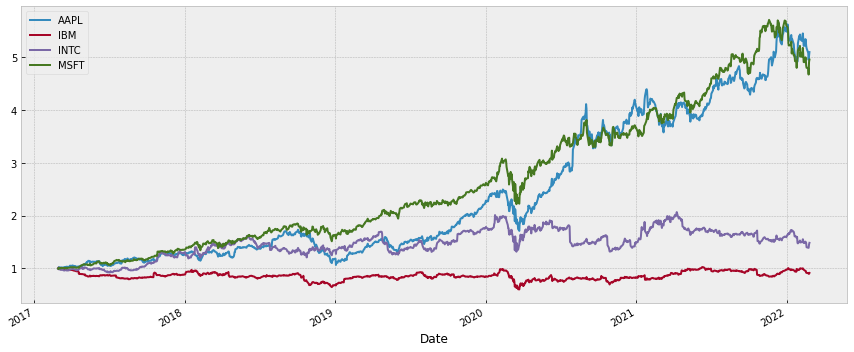

In [5]:
returns.cumsum().apply(np.exp).plot(figsize=(12,5))
plt.tight_layout()
plt.show()

In [6]:
avg_returns = returns.mean().values * 252
cov_mat = returns.cov().values * 252

In [7]:
weights = cp.Variable(len(tickers))
gamma = cp.Parameter(nonneg=True)
portfolio_returns = avg_returns * weights
portfolio_volatility = cp.quad_form(weights, cov_mat)
obj_func = cp.Maximize(portfolio_returns - gamma * portfolio_volatility)
problem = cp.Problem(obj_func, [cp.sum(weights) == 1, weights >= 0])

In [8]:
n_points = 1000
efficient_returns = np.zeros(n_points)
efficient_volatility = np.zeros(n_points)
efficient_weights = []
gamma_range = np.logspace(-3, 3, num=n_points)

for i in tqdm(range(n_points), leave=False):
    gamma.value = gamma_range[i]
    problem.solve()
    efficient_volatility[i] = cp.sqrt(portfolio_volatility).value
    efficient_returns[i] = portfolio_returns.value
    efficient_weights.append(weights.value)
    
weights_df = pd.DataFrame(data=np.round(efficient_weights, 5), columns=tickers, index=gamma_range)
sharpe_ratios = efficient_returns / efficient_volatility

  0%|          | 0/1000 [00:00<?, ?it/s]

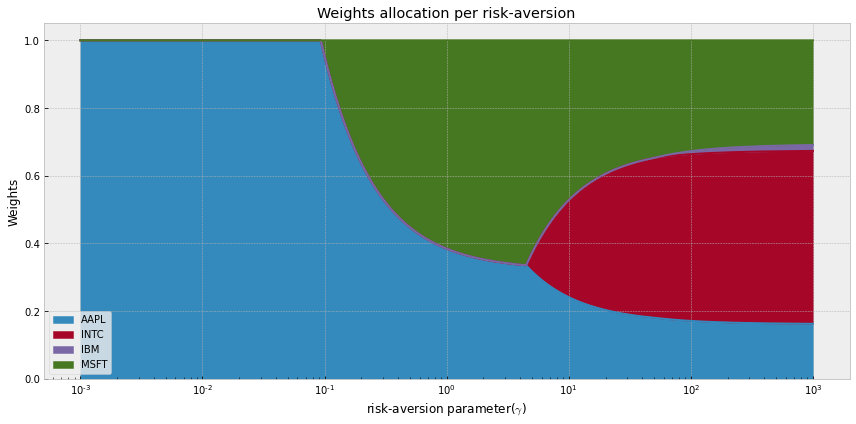

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
weights_df.plot(kind='area', stacked=True, ax=ax, logx=True)
ax.set_xlabel('risk-aversion parameter($\gamma$)')
ax.set_ylabel('Weights')
ax.set_title("Weights allocation per risk-aversion")
plt.tight_layout()
plt.show()

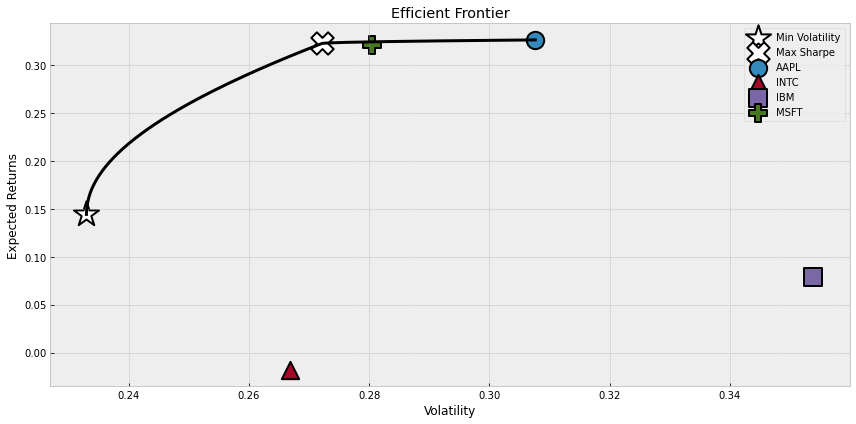

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(efficient_volatility, efficient_returns, linewidth=3, color='k')
ax.set_title('Efficient Frontier')
ax.set_xlabel('Volatility')
ax.set_ylabel('Expected Returns')

min_idx = np.argmin(efficient_volatility)
plt.scatter(efficient_volatility[min_idx], efficient_returns[min_idx], 
            marker='*', s=700, c='w', edgecolors='k', linewidths=2, 
            label='Min Volatility')

sharpe_idx = np.argmax(sharpe_ratios)
plt.scatter(efficient_volatility[sharpe_idx], efficient_returns[sharpe_idx], 
            marker='X', s=500, c='w', edgecolors='k', linewidths=2, 
            label='Max Sharpe')

markers = ['o', '^', 's', 'P']
for i, ticker in enumerate(tickers):
    ret = avg_returns[i]
    vol = np.sqrt(cov_mat[i, i])
    plt.scatter(vol, ret, marker=markers[i], s=300, 
                label=ticker, edgecolors='k', linewidths=2)

ax.legend()

plt.tight_layout()
plt.show()